In [41]:
from models.cifrador_homomorfico_parcial import CifradorHomomorficoParcial
from models.cifrador_homomorfico_completo import CifradorHomomorficoCompleto
from models.cifrador_asimetrico import CifradorAsimetrico
import time
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
# Las librerías de seaborn tiran un warning, puse esta celda para ignorarlas
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
def wrapped(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        elapsed = end - start
        return result, elapsed

    return wrapper

In [44]:
@wrapped
def encriptar(cifrador, numero):
    return cifrador.encriptar(numero)


@wrapped
def desencriptar(cifrador, numero):
    return cifrador.desencriptar(numero)


@wrapped
def suma(numero1, numero2):
    return numero1 + numero2

In [45]:
def tiempos_operacion_cifrador(cifrador, numeros, operacion):
    tiempos = []
    numeros_operacion = []
    for numero in numeros:
        numero_operado, elapsed_time = operacion(cifrador, numero)
        tiempos.append(elapsed_time)
        numeros_operacion.append(numero_operado)
    return tiempos, numeros_operacion


def tiempos_operaciones_algebraicas(numeros1, numeros2, operacion):
    if len(numeros1) != len(numeros2):
        raise ValueError("Las listas de numeros tienen diferentes longitudes")
    tiempos = []
    numeros_operacion = []
    for numero1, numero2 in zip(numeros1, numeros2):
        numero_operado, elapsed_time = operacion(numero1, numero2)
        tiempos.append(elapsed_time)
        numeros_operacion.append(numero_operado)
    return tiempos, numeros_operacion

In [46]:
def tiempos_cifrado(cifrador, numeros):
    return tiempos_operacion_cifrador(cifrador, numeros, encriptar)


def tiempos_descifrado(cifrador, numeros_encriptados):
    return tiempos_operacion_cifrador(cifrador, numeros_encriptados, desencriptar)


def tiempos_suma(numeros1, numeros2):
    return tiempos_operaciones_algebraicas(numeros1, numeros2, suma)

In [47]:
def guardar_plot(titulo):
    %matplotlib inline
    titulo_archivo = titulo.lower().replace(' ', '_')
    plt.savefig(os.getcwd() + f'/imagenes/{titulo_archivo}.png')

In [48]:
def barplot_tiempos(tiempos, titulo, xlabel):
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))

    sns.histplot(tiempos, bins=10, kde=True, color='skyblue', stat='count', edgecolor='black')

    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.title(titulo, fontsize=16)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    guardar_plot(titulo)
    plt.show()

In [49]:
def plot_precision_comparison(precision_ckks, precision_parcial, random_numbers):
    def calcular_presicion_relativa(original, decrypted):
        return (1 - (original - decrypted) / original) * 100

    precision_ckks = [calcular_presicion_relativa(original, decrypted) for original, decrypted in
                      zip(random_numbers, precision_ckks)]
    precision_parcial = [calcular_presicion_relativa(original, decrypted) for original, decrypted in
                         zip(random_numbers, precision_parcial)]

    sns.set(style="whitegrid")

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    plt.subplots_adjust(top=0.85, hspace=0.5)

    sns.boxplot(y=precision_ckks, ax=axes[0], color='skyblue')
    axes[0].set_title('Precisión Cifrador Homomórfico Completo CKKS')
    axes[0].set_ylabel('Precisión Relativa')

    sns.boxplot(y=precision_parcial, ax=axes[1], color='lightcoral')
    axes[1].set_title('Precisión Cifrador Homomórfico Parcial')
    titulo = 'Comparación de precisión entre cifradores al desencriptar'
    plt.suptitle(titulo, fontsize=16)
    guardar_plot(titulo)
    plt.show()

# Análisis de tiempos de cifrado

In [50]:
random.seed(42)
numeros_random_enteros = [random.randint(1, 10000) for _ in range(500)]
numeros_random_floats = [random.uniform(1.0, 10000.0) for _ in range(500)]

In [51]:
cifrador_homomorfico_parcial = CifradorHomomorficoParcial()
tiempos_del_parcial, numeros_encriptados_parcial = tiempos_cifrado(cifrador_homomorfico_parcial, numeros_random_floats)

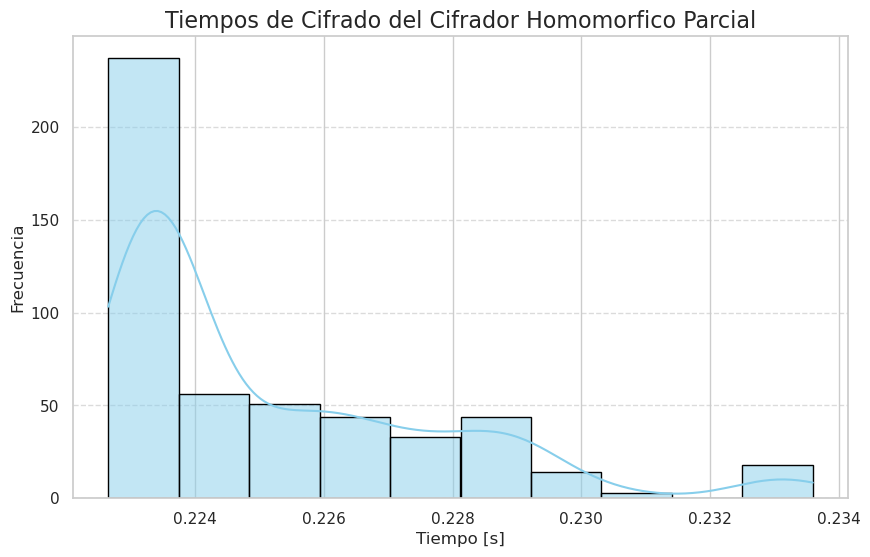

In [52]:
barplot_tiempos(tiempos_del_parcial, 'Tiempos de Cifrado del Cifrador Homomorfico Parcial', 'Tiempo [s]')

In [53]:
cifrador_homomorfico_completo_bfv = CifradorHomomorficoCompleto()
tiempos_del_parcial_completo_bfv, numeros_encriptados_completo_bfv = tiempos_cifrado(cifrador_homomorfico_completo_bfv,
                                                                                     numeros_random_enteros)

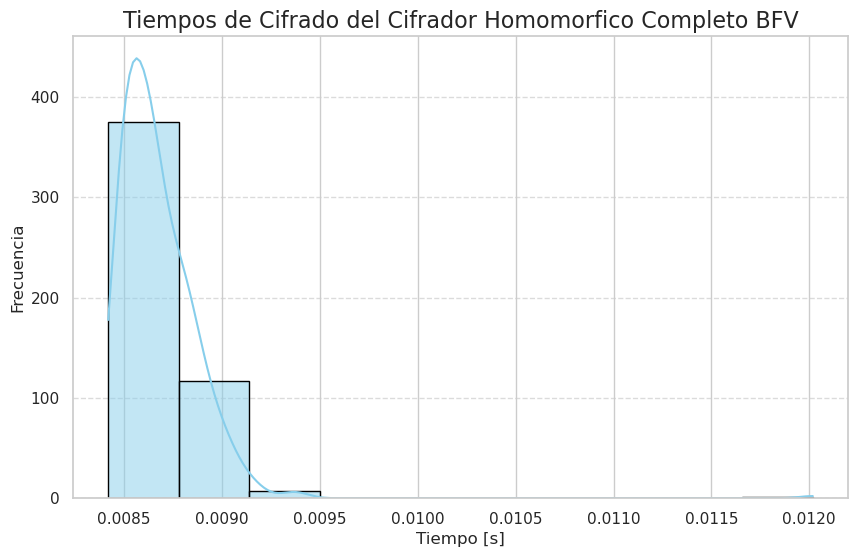

In [54]:
barplot_tiempos(tiempos_del_parcial_completo_bfv, 'Tiempos de Cifrado del Cifrador Homomorfico Completo BFV',
                'Tiempo [s]')

In [55]:
CKKS_PARAMS = {
    'scheme': 'CKKS',  # can also be 'ckks'
    'n': 2 ** 14,  # Polynomial modulus degree. For CKKS, n/2 values can be
    #  encoded in a single ciphertext.
    #  Typ. 2^D for D in [10, 15]
    'scale': 2 ** 30,  # All the encodings will use it for float->fixed point
    #  conversion: x_fix = round(x_float * scale)
    #  You can use this as default scale or use a different
    #  scale on each operation (set in HE.encryptFrac)
    'qi_sizes': [60, 30, 30, 30, 60]  # Number of bits of each prime in the chain.
    # Intermediate values should be  close to log2(scale)
    # for each operation, to have small rounding errors.
}

In [56]:
cifrador_homomorfico_completo_ckks = CifradorHomomorficoCompleto(context_gen_params=CKKS_PARAMS)
tiempos_del_parcial_completo_ckks, numeros_encriptados_completo_ckks = tiempos_cifrado(
    cifrador_homomorfico_completo_ckks,
    numeros_random_floats)

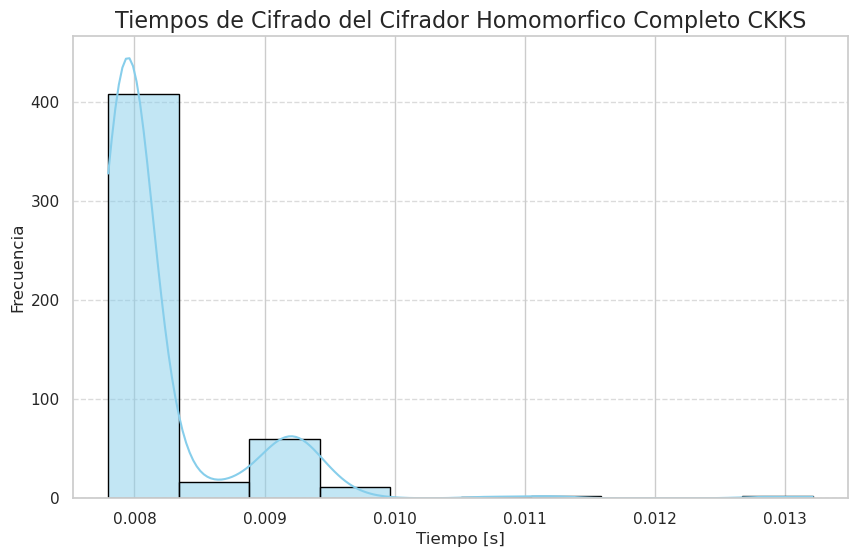

In [57]:
barplot_tiempos(tiempos_del_parcial_completo_ckks, 'Tiempos de Cifrado del Cifrador Homomorfico Completo CKKS',
                'Tiempo [s]')

In [58]:
cifrador_homomorfico_asimetrico = CifradorAsimetrico()
tiempos_del_parcial_asimetricos, numeros_encriptados_asimetricos = tiempos_cifrado(cifrador_homomorfico_asimetrico,
                                                                                   numeros_random_enteros)

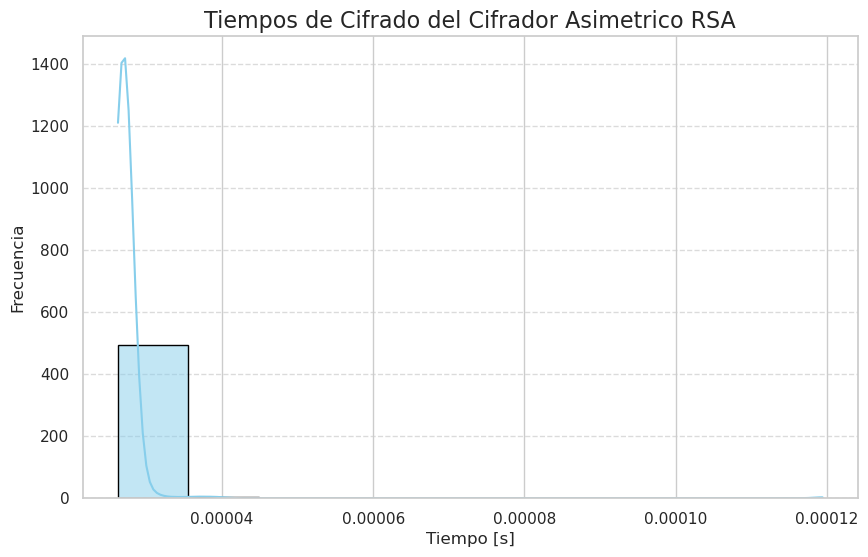

In [59]:
barplot_tiempos(tiempos_del_parcial_asimetricos, 'Tiempos de Cifrado del Cifrador Asimetrico RSA', 'Tiempo [s]')

# Análisis de tiempos para desencriptar

In [60]:
tiempos_desencriptado_parcial, numeros_desencriptados_parcial = tiempos_descifrado(cifrador_homomorfico_parcial,
                                                                                   numeros_encriptados_parcial)

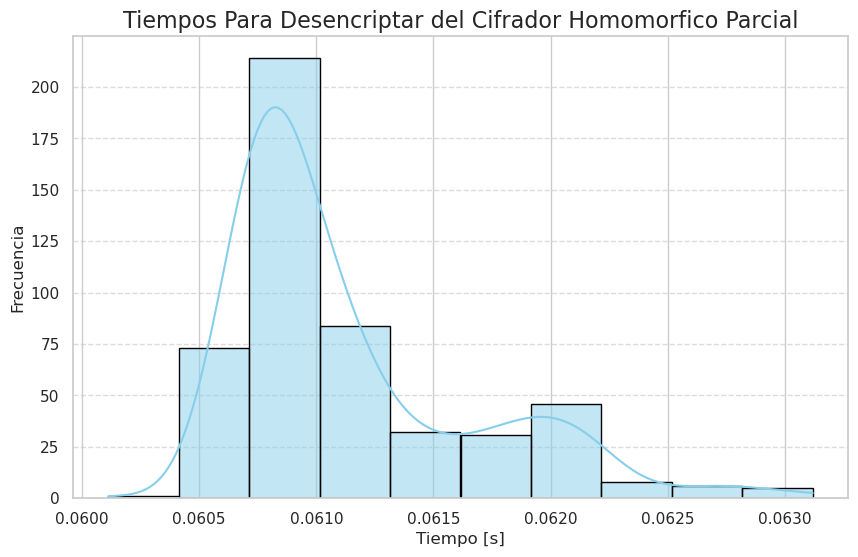

In [61]:
barplot_tiempos(tiempos_desencriptado_parcial, 'Tiempos Para Desencriptar del Cifrador Homomorfico Parcial',
                'Tiempo [s]')

In [62]:
tiempos_desencriptado_completo_bfv, numeros_desencriptados_completo_bfv = tiempos_descifrado(
    cifrador_homomorfico_completo_bfv,
    numeros_encriptados_completo_bfv)

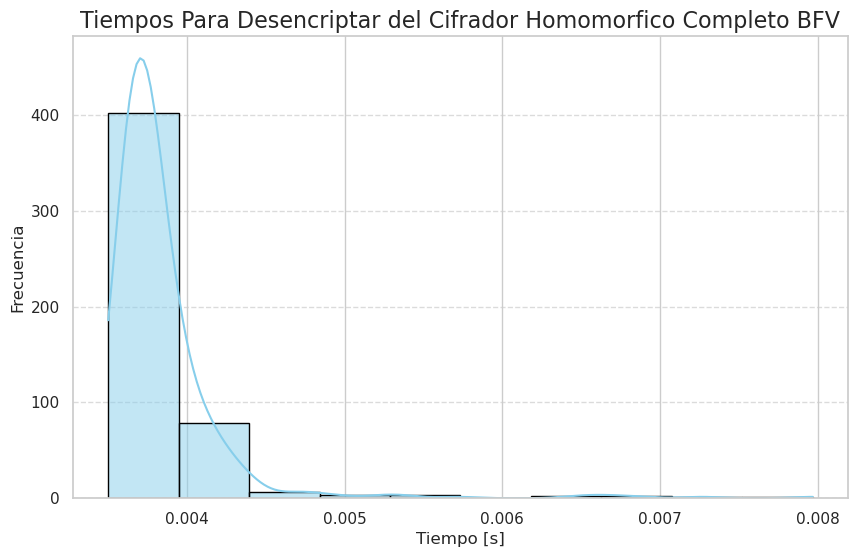

In [63]:
barplot_tiempos(tiempos_desencriptado_completo_bfv, 'Tiempos Para Desencriptar del Cifrador Homomorfico Completo BFV',
                'Tiempo [s]')

In [64]:
tiempos_desencriptado_completo_ckks, numeros_desencriptados_completo_ckks = tiempos_descifrado(
    cifrador_homomorfico_completo_ckks,
    numeros_encriptados_completo_ckks)

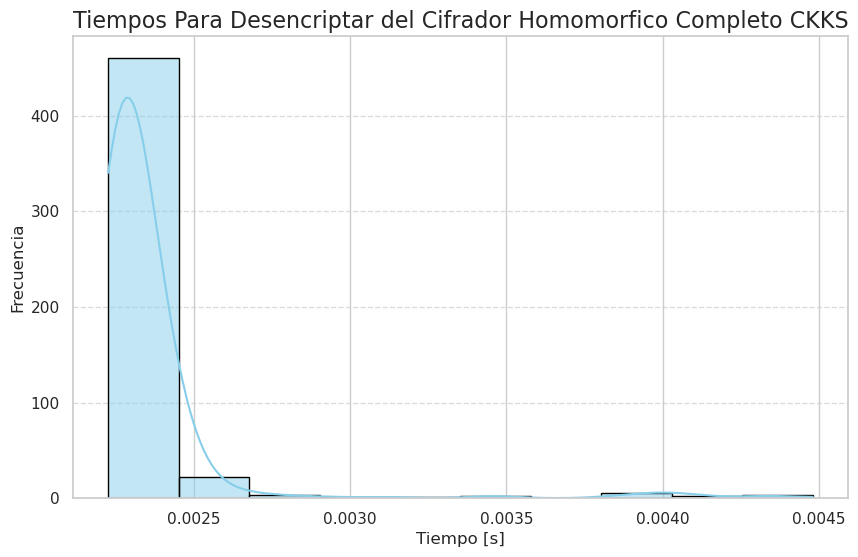

In [65]:
barplot_tiempos(tiempos_desencriptado_completo_ckks, 'Tiempos Para Desencriptar del Cifrador Homomorfico Completo CKKS',
                'Tiempo [s]')

## Además verificamos la presición de los numeros

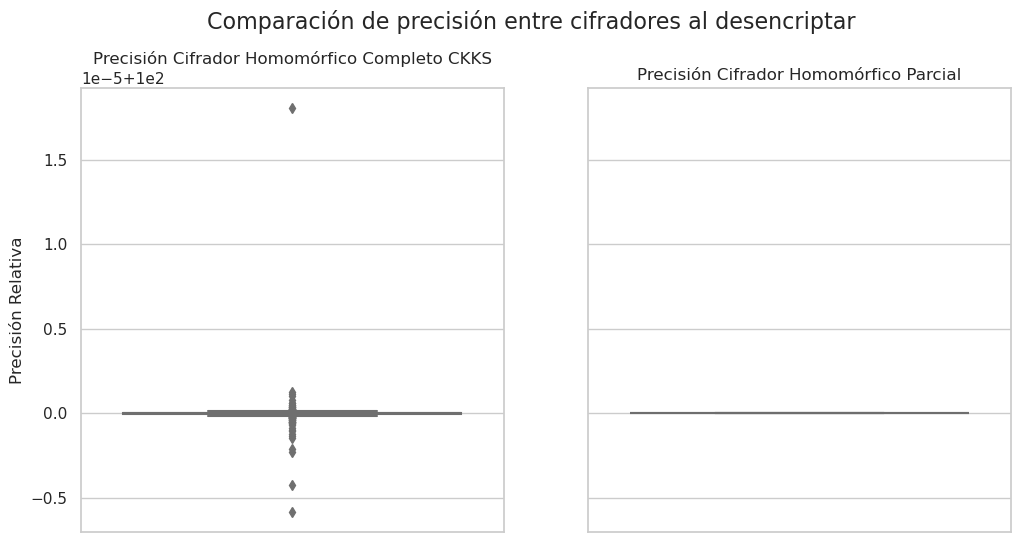

In [75]:
plot_precision_comparison(numeros_desencriptados_completo_ckks, numeros_desencriptados_parcial, numeros_random_floats)

In [67]:
tiempos_desencriptado_asimetricos, numeros_desencriptados_asimetricos = tiempos_descifrado(
    cifrador_homomorfico_asimetrico,
    numeros_encriptados_asimetricos)

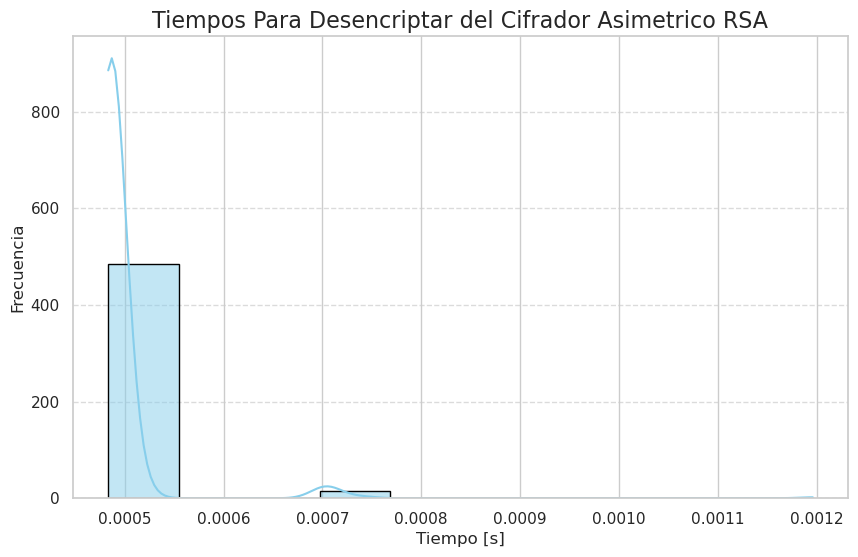

In [68]:
barplot_tiempos(tiempos_desencriptado_asimetricos, 'Tiempos Para Desencriptar del Cifrador Asimetrico RSA',
                'Tiempo [s]')

# Análisis de tiempos de suma

In [69]:
mitad = len(numeros_encriptados_parcial) // 2
numeros_encriptados_parcial1 = numeros_encriptados_parcial[mitad:]
numeros_encriptados_parcial2 = numeros_encriptados_parcial[:mitad]

tiempo_suma_encriptados_parcial, suma_encriptada_parcial = tiempos_suma(numeros_encriptados_parcial1,
                                                                        numeros_encriptados_parcial2)

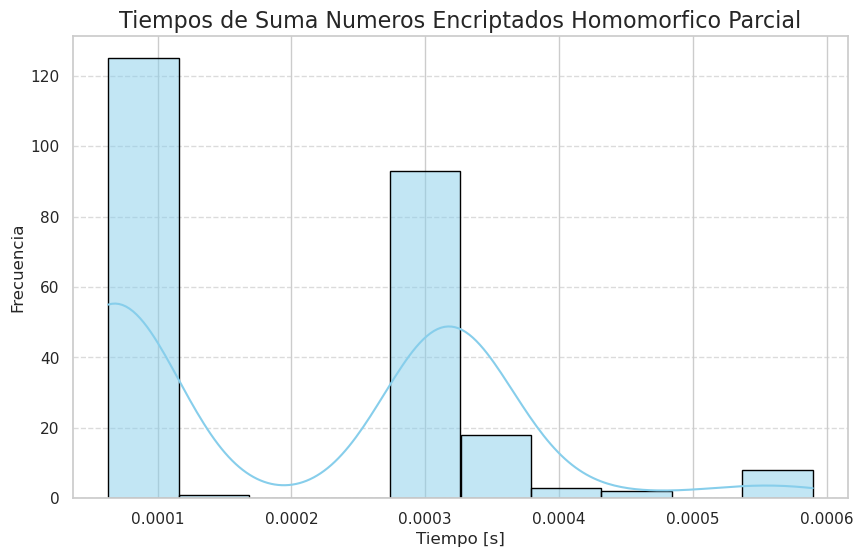

In [70]:
barplot_tiempos(tiempo_suma_encriptados_parcial, titulo='Tiempos de Suma Numeros Encriptados Homomorfico Parcial',
                xlabel='Tiempo [s]')

In [71]:
mitad = len(numeros_encriptados_completo_bfv) // 2
numeros_encriptados_completo_bfv1 = numeros_encriptados_completo_bfv[mitad:]
numeros_encriptados_completo_bfv2 = numeros_encriptados_completo_bfv[:mitad]

tiempo_suma_encriptados_completo_bfv, suma_encriptada_completo_bfv = tiempos_suma(numeros_encriptados_completo_bfv1,
                                                                                  numeros_encriptados_completo_bfv2)

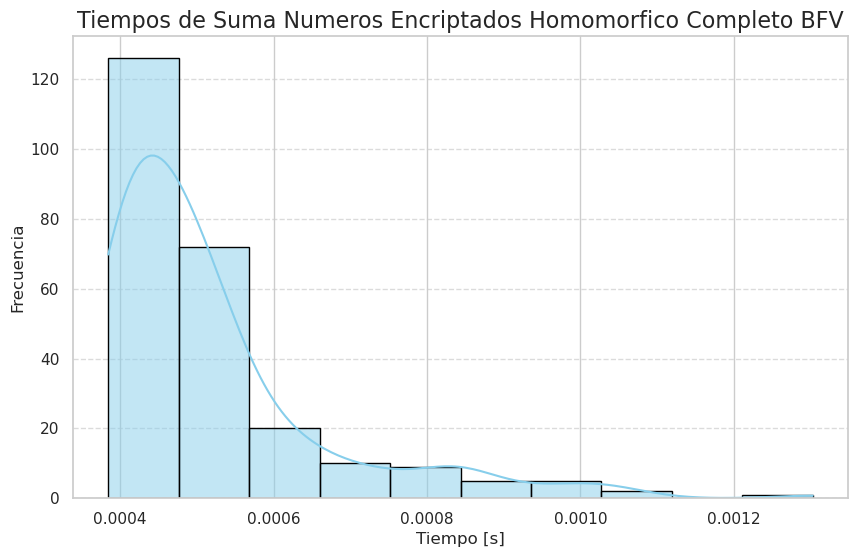

In [72]:
barplot_tiempos(tiempo_suma_encriptados_completo_bfv,
                titulo='Tiempos de Suma Numeros Encriptados Homomorfico Completo BFV',
                xlabel='Tiempo [s]')

In [73]:
mitad = len(numeros_encriptados_completo_ckks) // 2
numeros_encriptados_completo_ckks1 = numeros_encriptados_completo_ckks[mitad:]
numeros_encriptados_completo_ckks2 = numeros_encriptados_completo_ckks[:mitad]

tiempo_suma_encriptados_completo_ckks, suma_encriptada_completo_ckks = tiempos_suma(numeros_encriptados_completo_ckks1,
                                                                                  numeros_encriptados_completo_ckks2)

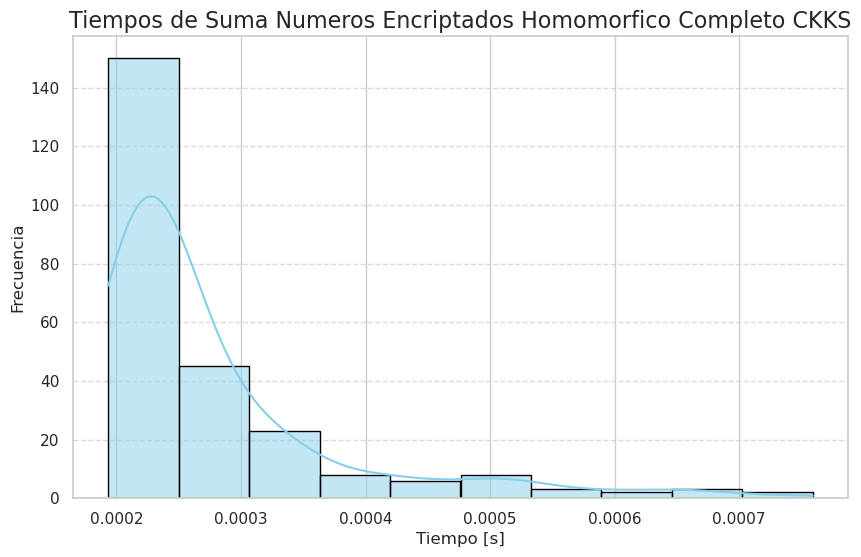

In [74]:
barplot_tiempos(tiempo_suma_encriptados_completo_ckks,
                titulo='Tiempos de Suma Numeros Encriptados Homomorfico Completo CKKS',
                xlabel='Tiempo [s]')

# Análisis de tiempos de resta

# Análisis de tiempos de multiplicación

## Multiplicación número encriptado con número sin encriptar

## Multiplicación de dos números encriptados